In [12]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)

test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ])
)

def plot(x):
    img = (np.array(x.detach().cpu(), dtype='float')).reshape(28, 28)

    plt.imshow(img, cmap='gray')
    plt.show()

x = train.data.float() / 255
y = train.targets

x = x.view(x.size(0), -1)
print(x.shape, y.shape)

input_size = x.size(-1)
output_size = int(max(y)) + 1

print('input_size : %d, output_size : %d' % (input_size, output_size))

# Train Valid ration

ratio = [.8, .2]

train_cnt = int(x.size(0) * ratio[0])
valid_cnt = int(x.size(0) * ratio[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print("Train %d, Valid : %d / Test : %d samples" % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([60000, 784]) torch.Size([60000])
input_size : 784, output_size : 10
Train 48000, Valid : 12000 / Test : 10000 samples
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [13]:
n_epochs = 1000
batch_size = 256
print_interval = 10
early_stop = 50

from copy import deepcopy

lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [14]:
class Block(nn.Module):
    def __init__(self,
                 input_size,
                 output_size,
                 use_batch_norm=True,
                 dropout_p=.4):
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p

        super().__init__()

        def get_regularizer(use_batch_norm, size):
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)
        
        self.block = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(),
            get_regularizer(use_batch_norm, output_size)
        )
    
    def forward(self, x):
        # |x| = (batch_size, input_size)
        y = self.block(x)
        # |y| = (batch_size, output_size)

        return y

In [15]:
class MyModel(nn.Module):

    def __init__(self,
                 input_size,
                 output_size,
                 use_batch_norm =True,
                 dropout_p=.4):
        
        super().__init__()

        self.layers = nn.Sequential(
            Block(input_size, 500, use_batch_norm, dropout_p),
            Block(500, 400, use_batch_norm, dropout_p),
            Block(400, 300, use_batch_norm, dropout_p),
            Block(300, 200, use_batch_norm, dropout_p),
            Block(200, 100, use_batch_norm, dropout_p),
            Block(100, 50, use_batch_norm, dropout_p),
            nn.Linear(50, output_size),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x):
        # |x| = (batch_size, input_size)
        y = self.layers(x)
        # |y| = (batch_size, output_size)

        return y

In [16]:
model = MyModel(input_size, output_size, use_batch_norm=True)
print(model)

MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(200, e

### 학습

In [17]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

import time

train_history, valid_history = [], []

start = time.time()
init_time = start
for i in range(n_epochs):
    model.train()

    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)


    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
        train_loss += float(loss)

    train_loss = train_loss / len(x_)

    model.eval()
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze()) # y_hat과 y_hat_i의 차원을 맞춰주기 위함

            valid_loss += float(loss)

            y_hat += [y_hat_i]
        
        valid_loss = valid_loss / len(x_)

        train_history += [train_loss]
        valid_history += [valid_loss]

        if(i + 1) % print_interval == 0:
            print('epoch %d/%d : train_loss=%.4e valid_loss=%.4e lowest_loss=%.4e elapsed_time=%.2fsec' % 
                  (i + 1, n_epochs, train_loss, valid_loss, lowest_loss, time.time() - start)
            )
            start = time.time()

        if valid_loss <= lowest_loss:
            lowest_loss = valid_loss
            lowest_epoch = i

            best_model = deepcopy(model.state_dict())
        else:
            if early_stop > 0 and lowest_epoch + early_stop < i + 1:
                print("There is no improvment during last %d epochs." % early_stop)
                break

print("The best validation loss from epoch %d: %.4e" % (lowest_epoch + 1, lowest_loss))

# Load best epoch's model
model.load_state_dict(best_model)
print("Total elapsed time: %.2fsec" % (time.time() - init_time))

epoch 10/1000 : train_loss=2.3968e-02 valid_loss=9.7443e-02 lowest_loss=8.1905e-02 elapsed_time=28.74sec
epoch 20/1000 : train_loss=1.2374e-02 valid_loss=9.4805e-02 lowest_loss=8.1905e-02 elapsed_time=30.27sec
epoch 30/1000 : train_loss=7.7370e-03 valid_loss=9.6985e-02 lowest_loss=8.1905e-02 elapsed_time=30.49sec
epoch 40/1000 : train_loss=7.2883e-03 valid_loss=1.0148e-01 lowest_loss=8.1905e-02 elapsed_time=31.35sec
epoch 50/1000 : train_loss=4.8326e-03 valid_loss=1.0202e-01 lowest_loss=8.1905e-02 elapsed_time=32.75sec
There is no improvment during last 50 epochs.
The best validation loss from epoch 8: 8.1905e-02
Total elapsed time: 184.44sec


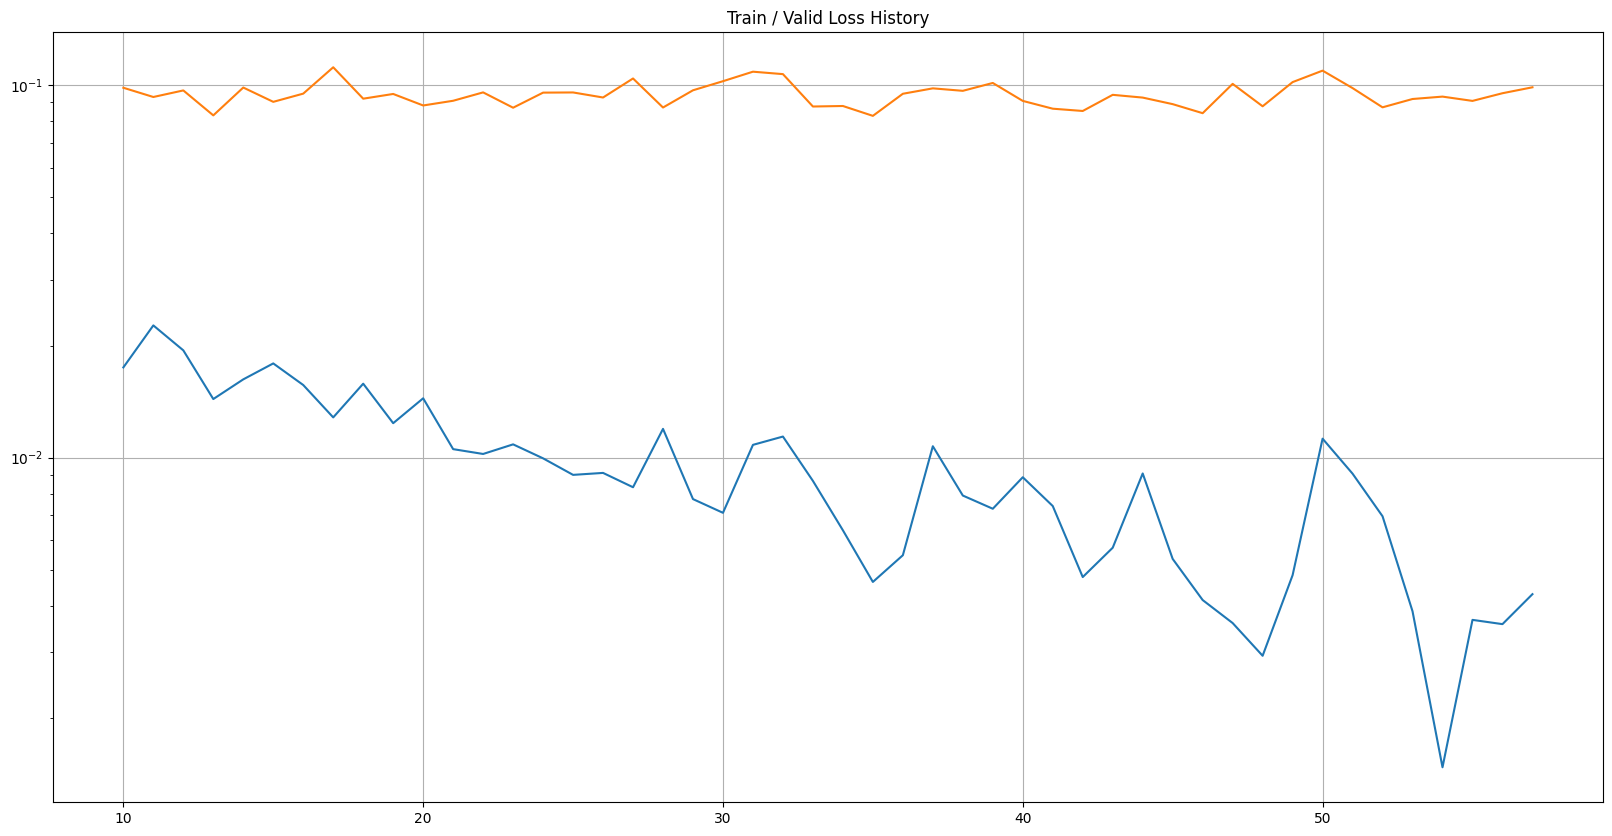

In [18]:
plot_from = 10

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(range(plot_from, len(train_history)), train_history[plot_from:], label='Train Loss')
plt.plot(range(plot_from, len(valid_history)), valid_history[plot_from:], label='Valid Loss')
plt.yscale('log')
plt.show()

In [23]:
test_loss = 0
y_hat = []

model.eval()
with torch.no_grad():
    x_ = x[-1].split(batch_size, dim=0)
    y_ = y[-1].split(batch_size, dim=0)

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        test_loss += loss # Gradient is already detached.

        y_hat += [y_hat_i]

test_loss = test_loss / len(x_)
y_hat = torch.cat(y_hat, dim=0)

print("Test loss: %.4e" % test_loss)

Test loss: 6.9905e-02


In [25]:
correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.9793


In [20]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [26]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
             index=['true_%d' % i for i in range(10)],
             columns=['pred_%d' % i for i in range(10)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,969,1,0,1,1,2,1,1,3,1
true_1,0,1120,6,2,0,0,2,4,1,0
true_2,5,0,1011,4,1,0,0,5,5,1
true_3,0,0,5,987,0,10,0,4,2,2
true_4,1,1,1,0,960,0,4,2,1,12
true_5,2,0,0,8,2,872,4,0,2,2
true_6,4,4,1,1,7,5,931,0,5,0
true_7,1,3,7,0,1,0,0,1010,1,5
true_8,1,0,2,7,3,4,0,3,952,2
true_9,2,2,0,7,6,3,0,5,3,981
